In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import lmfit
from pytz import timezone
import vaex
import pvlib

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show  # noqa: E402

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'

GLOBAL_DT = 1

def input_output_response_to_pandas(response: ct.input_output_response):
    # until this gets merged: https://github.com/python-control/python-control/issues/957
    data = {'time': response.time}
    if response.ninputs > 0:
        data.update(
            {name: response.inputs[i] for i, name in enumerate(response.input_labels)})
    if response.noutputs > 0:
        data.update(
            {name: response.outputs[i] for i, name in enumerate(response.output_labels)})
    if response.nstates > 0:
        data.update(
            {name: response.states[i] for i, name in enumerate(response.state_labels)})
    return pd.DataFrame(data)

# Data

In [2]:
tzinfo = timezone("America/Sao_Paulo")

events = [
    {
        "name": "01.Curta",
        "start": pd.Timestamp(
            year=2020, month=1, day=29, hour=13, minute=51, second=59, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=29, hour=14, minute=20, second=25, tzinfo=tzinfo
        ),
    },
    {
        "name": "02.Longa",
        "start": pd.Timestamp(
            year=2020, month=1, day=30, hour=11, minute=16, second=45, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=30, hour=14, minute=55, second=30, tzinfo=tzinfo
        ),
    },
    {
        "name": "03.Revezamento",
        "start": pd.Timestamp(
            year=2020, month=1, day=31, hour=11, minute=23, second=23, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=31, hour=12, minute=27, second=23, tzinfo=tzinfo
        ),
    },
    {
        "name": "04.Curta",
        "start": pd.Timestamp(
            year=2020, month=2, day=1, hour=10, minute=15, second=15, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=1, hour=11, minute=37, second=28, tzinfo=tzinfo
        ),
    },
    {
        "name": "05.Curta",
        "start": pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=15, second=9, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=32, second=55, tzinfo=tzinfo
        ),
    },
    {
        "name": "07.Sprint",
        "start": pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=58, second=27, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=59, second=9, tzinfo=tzinfo
        ),
    },
]

events = pd.DataFrame(events).set_index('name')
events

,start,end
name,,
01.Curta,2020-01-29 13:51:59-03:00,2020-01-29 14:20:25-03:00
02.Longa,2020-01-30 11:16:45-03:00,2020-01-30 14:55:30-03:00
03.Revezamento,2020-01-31 11:23:23-03:00,2020-01-31 12:27:23-03:00
04.Curta,2020-02-01 10:15:15-03:00,2020-02-01 11:37:28-03:00
05.Curta,2020-02-01 13:15:09-03:00,2020-02-01 13:32:55-03:00
07.Sprint,2020-02-02 11:58:27-03:00,2020-02-02 11:59:09-03:00


'original columns:'

Index(['Battery Pack Voltage', 'Pilot Duty Cycle', 'Pilot Motor On',
       'Pilot Boat On', 'ESC Duty Cycle', 'Motor Angular Speed',
       'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage', 'MPPT 3 Input Voltage',
       'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Voltage', 'MPPT 1 Input Current', 'MPPT 2 Input Current',
       'MPPT 3 Input Current', 'MPPT 4 Input Current', 'MPPT 1 Duty Cycle',
       'MPPT 2 Duty Cycle', 'MPPT 3 Duty Cycle', 'MPPT 4 Duty Cycle',
       'MPPT 1 Input Power', 'MPPT 2 Input Power', 'MPPT 3 Input Power',
       'MPPT 4 Input Power', 'MPPTs Input Power', 'MPPT 1 Output Current',
       'MPPT 2 Output Current', 'MPPT 3 Output Current',
       'MPPT 4 Output Current', 'MPPTs Output Current', 'MPPT 1 Output Power',
       'MPPT 2 Output Power', 'MPPT 3 Output Power', 'MPPT 4 Output Power',
       'MPPTs Output Power', 'Battery Current', 'Battery Power',
       'ESC Input Curre

'renamed columns:'

{'Battery Pack Voltage': 'batt_v',
 'Battery Current': 'batt_i',
 'ESC Duty Cycle': 'esc_dt',
 'Motor Angular Speed': 'motor_w',
 'ESC Input Power': 'esc_p_in',
 'ESC Input Current': 'esc_i_in',
 'MPPT 1 Input Current': 'mppt1_ii',
 'MPPT 2 Input Current': 'mppt2_ii',
 'MPPT 3 Input Current': 'mppt3_ii',
 'MPPT 1 Input Voltage': 'mppt1_vi',
 'MPPT 2 Input Voltage': 'mppt2_vi',
 'MPPT 3 Input Voltage': 'mppt3_vi',
 'MPPT 1 Duty Cycle': 'mppt1_d',
 'MPPT 2 Duty Cycle': 'mppt2_d',
 'MPPT 3 Duty Cycle': 'mppt3_d',
 'MPPT 1 Output Current': 'mppt1_io',
 'MPPT 2 Output Current': 'mppt2_io',
 'MPPT 3 Output Current': 'mppt3_io',
 'Solar POA': 'solar_poa',
 'Wind Speed': 'wind_v',
 'Air Temperature': 'air_t'}

'selected columns:'

Index(['batt_v', 'batt_i', 'esc_dt', 'motor_w', 'esc_p_in', 'esc_i_in', 'mppt1_ii',
       'mppt2_ii', 'mppt3_ii', 'mppt1_vi', 'mppt2_vi', 'mppt3_vi', 'mppt1_d',
       'mppt2_d', 'mppt3_d', 'mppt1_io', 'mppt2_io', 'mppt3_io', 'solar_poa',
       'wind_v', 'air_t'],
      dtype='object')

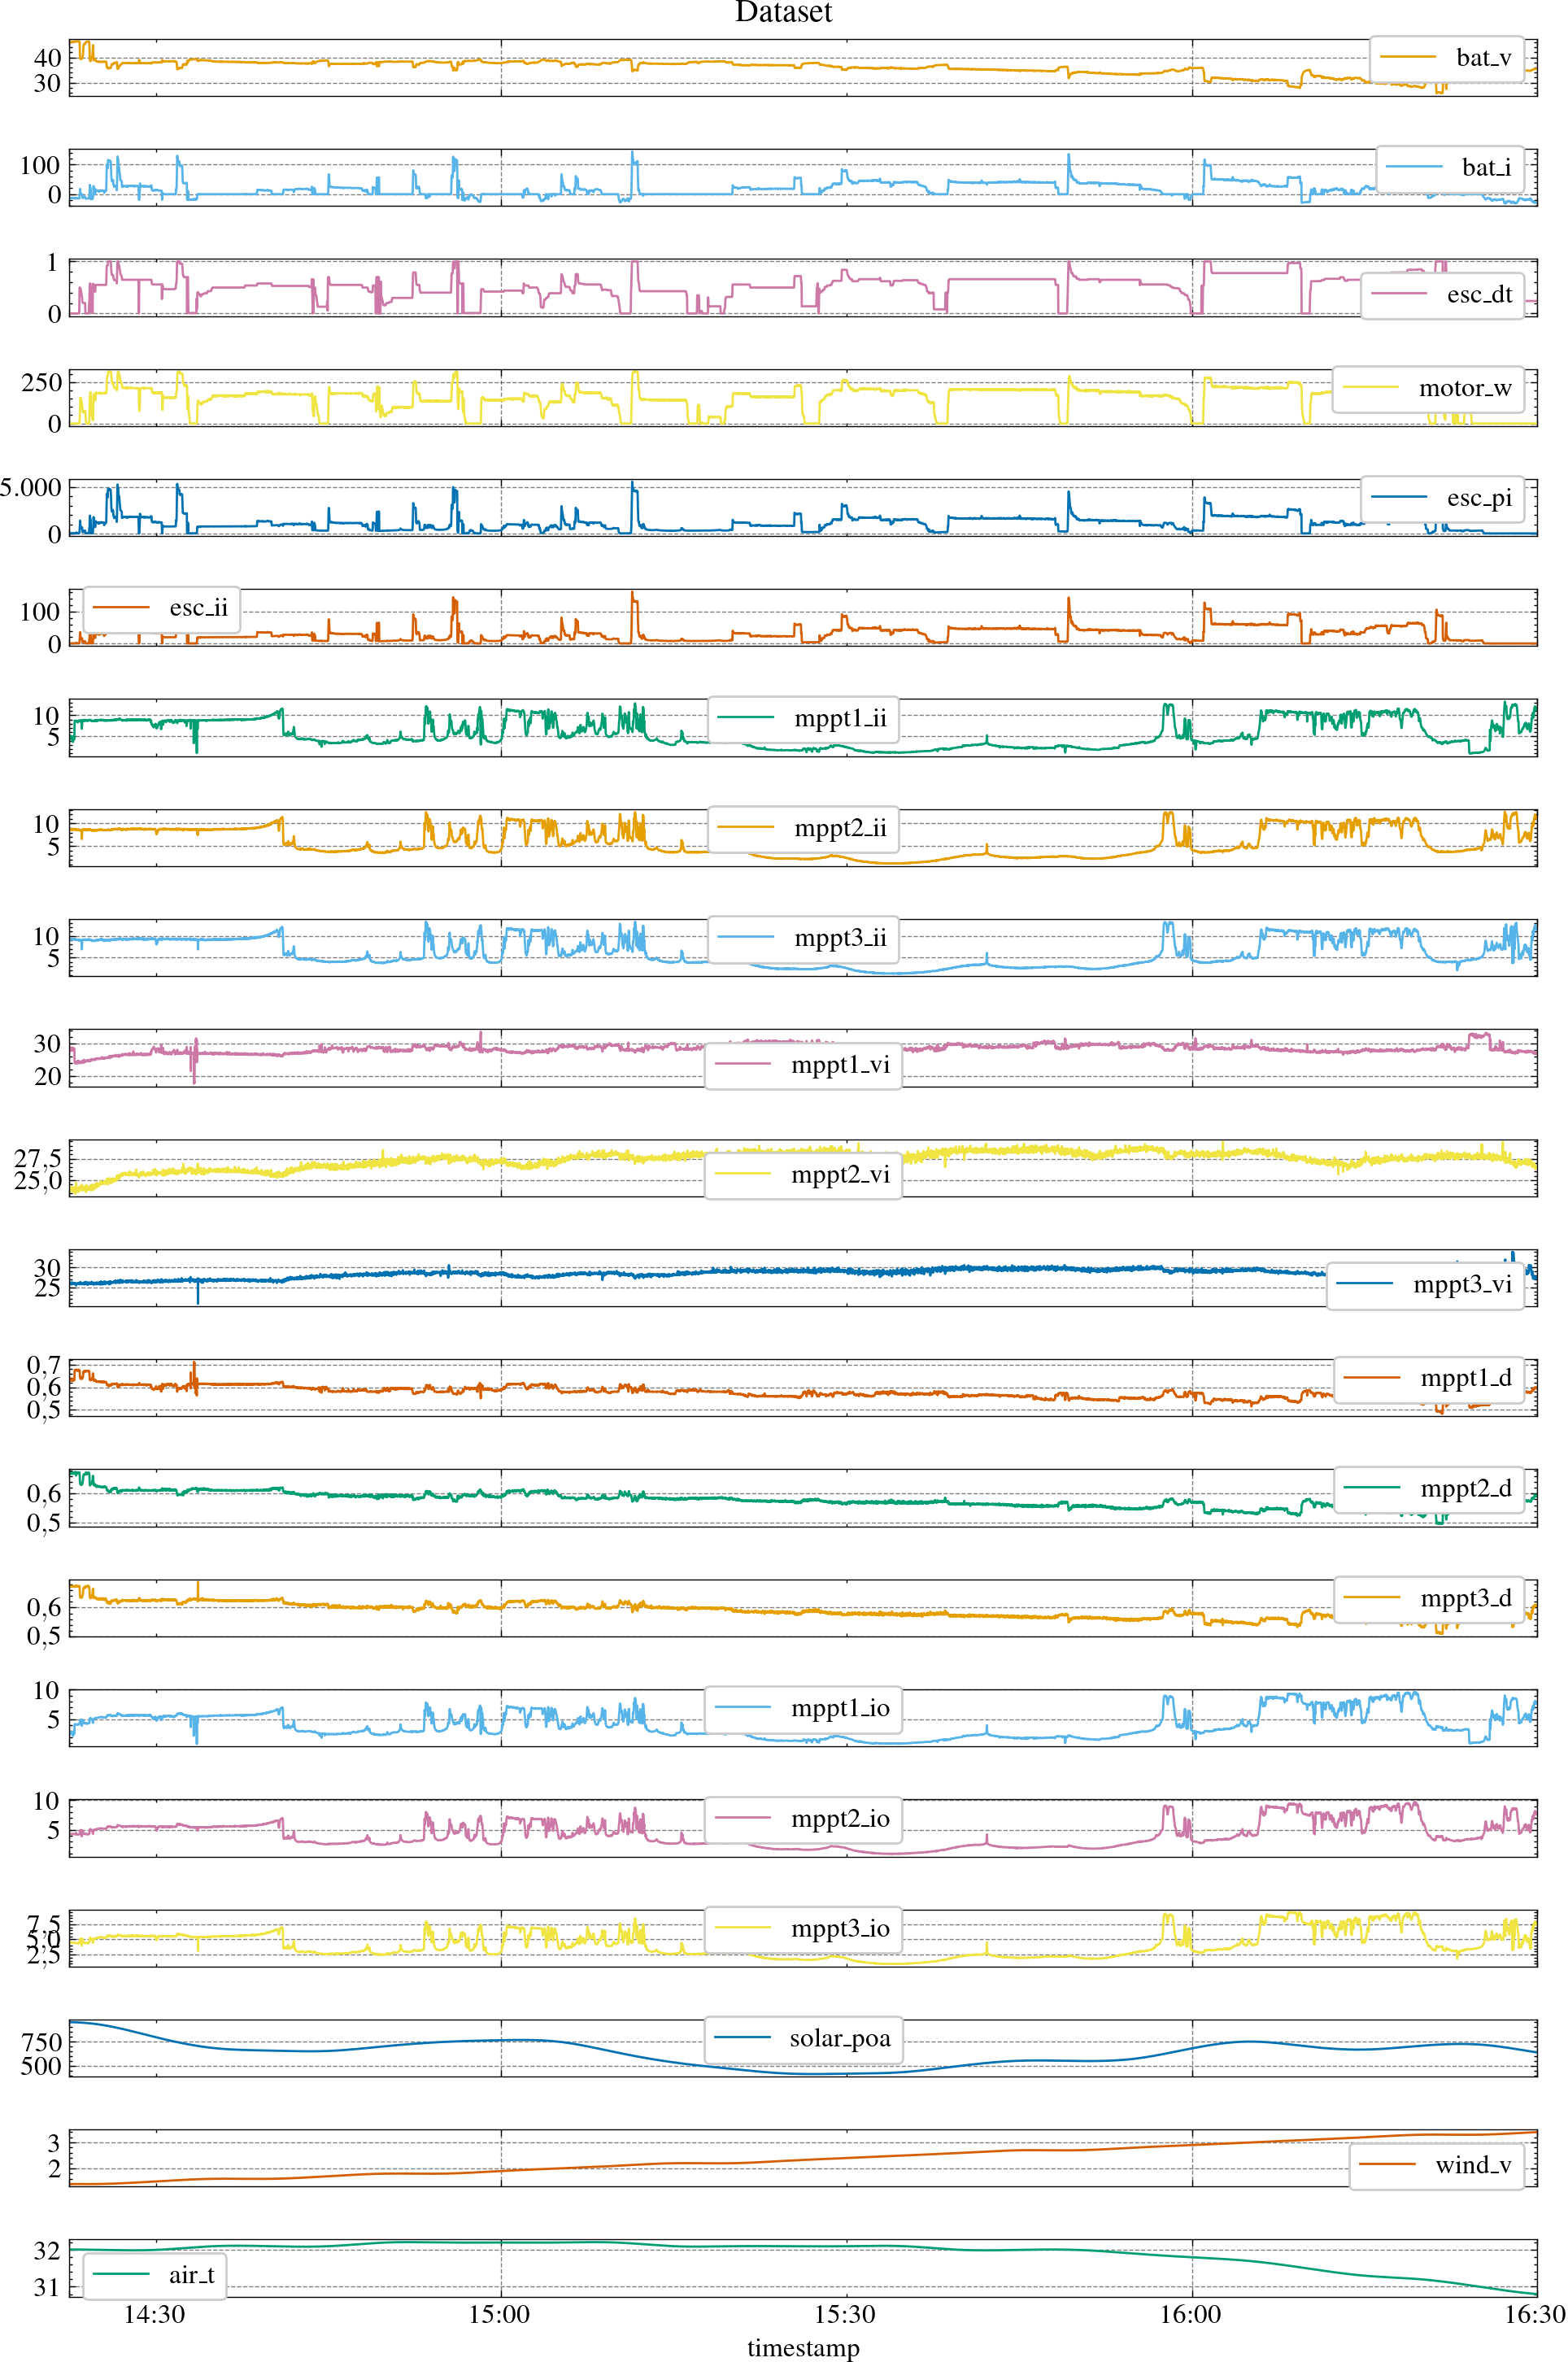

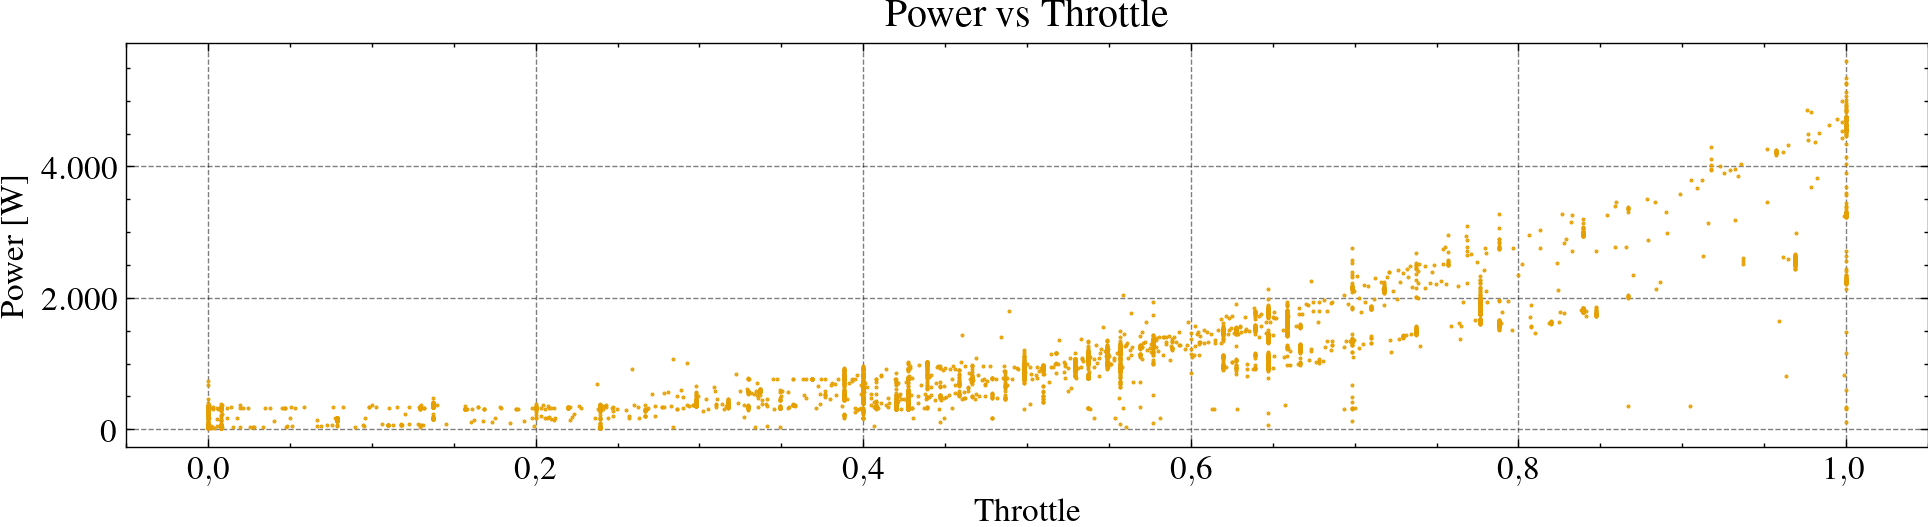

In [3]:
# From Revezamento
start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = vaex.from_csv("../../../models/2020/boat_data_1s.csv").to_pandas_df()
# df = vaex.from_csv("../../../models/2020/boat_data_100ms.csv").to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")
display('original columns:', df.columns)

renamed_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'esc_dt',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Power': 'esc_p_in',
    'ESC Input Current': 'esc_i_in',
    **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,4)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,4)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,4)},
    **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,4)},
    'Solar POA': 'solar_poa',
    'Wind Speed': 'wind_v',
    'Air Temperature': 'air_t',
}
display('renamed columns:', renamed_columns)

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

display('selected columns:', df.columns)

df = df.dropna()
df = df.resample('1s').mean().interpolate(method="time", limit_area='inside')
dfa = df.copy(deep=True)

df.plot(subplots=True, figsize=(10, 15))
plt.suptitle('Dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.title('Power vs Throttle')
plt.xlabel('Throttle')
plt.ylabel('Power [W]')
plt.scatter(df['esc_dt'], df['esc_p_in'], s=0.2)
plt.tight_layout()
plt.show()


# Propulsion Model

In [4]:
class Propeller:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the parameter values
        prop_K = params["prop_K"]
        prop_D = params["prop_D"]
        rho = params["rho"]

        # Get the inputs
        prop_w = u

        # Returns the Torque required by the Propeller
        return (prop_D ** 5) * rho * prop_K * (prop_w ** 2)

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="propeller",
            dt=params['dt'],
            states=None,
            inputs="w",
            outputs="Q",
            params=params,
        )

In [5]:
class Transmission:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the parameter values
        trans_eta = params["trans_eta"]
        trans_K = params["trans_K"]  # gear ratio as `output speed / input speed`

        # Get the inputs
        trans_w_in = u[0]
        trans_Qo = u[1]

        #
        trans_w_out = trans_w_in * trans_K
        trans_Qi = trans_Qo * trans_K / trans_eta

        return (trans_w_out, trans_Qi)

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="transmission",
            dt=params['dt'],
            states=None,
            inputs=["wi", "Qo"],
            outputs=["wo", "Qi"],
            params=params,
        )


In [6]:
class Motor:
    @classmethod
    def build(cls, params: dict):
        motor_K = params["motor_K"]
        motor_R = params["motor_R"]
        motor_L = params["motor_L"]
        motor_I_r = params["motor_I_r"]
        motor_B = params["motor_B"]
        motor_I_r_load = params["motor_I_r_load"]
        motor_I_r_total = motor_I_r + motor_I_r_load

        # From:
        #   didt = (-motor_R*motor_i -motor_K*motor_w + motor_v) / motor_L
        #   dwdt = (motor_K*motor_i -motor_B*motor_w - motor_Q) / motor_I_r_total
        # Considering:
        #   X = [motor_I, motor_w]
        #   U = [motor_V, motor_Q]
        #   Y = [motor_I, motor_w]

        # State Transition matrix, shape 'n,n' -> '2x2'
        A = np.array(
            [
                [-motor_R / motor_L, -motor_K / motor_L],
                [+motor_K / motor_I_r_total, -motor_B / motor_I_r_total],
            ],
        )

        # Input matrix, shape 'n,m' -> '2x2'
        B = np.array(
            [
                [+1 / motor_L, 0],
                [0, -1 / motor_I_r_total],
            ],
        )

        # Output matrix, shape 'p,n' -> '3x2'
        C = np.array(
            [
                [1, 0],
                [0, 1],
            ],
        )

        # Remaining matrix, shape 'p,m' -> '3x2'
        D = np.array(
            [
                [0, 0],
                [0, 0],
            ],
        )

        sys = ct.ss(
            A,
            B,
            C,
            D,
            name="motor",
            states=["I", "w"],
            inputs=["V", "Q"],
            outputs=["I", "w"],
        ).sample(params['dt'])

        return ct.ss(
            sys.A,
            sys.B,
            sys.C,
            sys.D,
            name="motor",
            dt=params['dt'],
            states=["I", "w"],
            inputs=["V", "Q"],
            outputs=["I", "w"],
        )

In [7]:
class ESC:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        esc_eta = params['esc_eta']

        # Get the inputs
        esc_D = u[0]
        esc_Vi = u[1]
        esc_Io = u[2]

        # Saturate esc_D
        esc_D = np.clip(esc_D, 0, 1)

        #
        esc_Vo = esc_D * esc_Vi
        esc_Ii = esc_Io * esc_D / esc_eta

        return (esc_Vo, esc_Ii)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="esc",
            dt=params['dt'],
            states=None,
            inputs=["D", "Vi", "Io"],
            outputs=["Vo", "Ii"],
            params=params,
        )


In [8]:
class Propulsion:
    @classmethod
    def build(cls, params: dict):
        return ct.interconnect(
            (
                Propeller.build(params),
                Transmission.build(params),
                Motor.build(params),
                ESC.build(params),
            ),
            name="propulsion",
            dt=params['dt'],
            connections=[
                ["propeller.w", "transmission.wo"], ["transmission.Qo", "propeller.Q"],  # Transmission to Propeller
                ["transmission.wi", "motor.w"], ["motor.Q", "transmission.Qi"],  # Motor to Transmission
                ["motor.V", "esc.Vo"], ["esc.Io", "motor.I"],  # ESC to Motor
            ],
            inplist=["esc.D", "esc.Vi"],
            inputs=["D", "Vi"],
            outlist=["esc.Ii", "motor.w"],
            outputs=["Ii", "w"],
        )

In [9]:
propulsion_params = {
    'dt': GLOBAL_DT,
    'motor_R': 0.033757265716427315,
    'motor_L': 0.0010492267299141082,
    'motor_B': 0.003901852250197858,
    'motor_I_r': 0.039200000000000006,
    'motor_I_r_load': 7.740892852532529e-05,
    'motor_K': 0.10324265711774457,
    'prop_K': 0.0016398967597139407,
    'prop_D': 0.20511514437186884,
    'rho': 1025,
    'trans_eta': 0.95,
    'esc_eta': 0.8,
    'trans_k': 0.5909090909090909
}

In [10]:
Propulsion.build(propulsion_params)

<InterconnectedSystem:propulsion:['D', 'Vi']->['Ii', 'w']>

# Generation Model


In [11]:
class SolarPanelDiodeModel:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        Iph_STC = params['pv_Iph_STC']
        I0_STC = params['pv_I0_STC']
        Rs_STC = params['pv_Rs_STC']
        Rp_STC = params['pv_Rp_STC']
        a_STC = params['pv_a_STC']
        Asc = params['pv_Asc']
        Eg_STC = params['pv_Eg_STC']
        dEgdT_STC = params['pv_dEgdT_STC']
        Tc_STC = params['pv_Tc_STC']
        G_STC = params['pvs_g_STC']

        # Inputs
        G = u[0]
        Tc = u[1]
        Vpv = u[2]

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        return np.clip(pvlib.pvsystem.i_from_v(Vpv, photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw'), a_min=0, a_max=None)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="pv_diode_model",
            dt=params['dt'],
            states=None,
            inputs=['G', 'Tc', 'V'],
            outputs=['I'],
            params=params,
        )


In [12]:
class PVCellThermalModel:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        alpha = params['pv_th_alpha']  # The light absorptance of the module
        u0 = params['pv_th_u0']  # Combined heat transfer coefficient at zero wind speed [(W/m^2)/C]
        u1 = params['pv_th_u1']  # Influence of wind speed on combined heat transfer coefficient [(W/m^2)/ºC/(m/s)]

        # Inputs
        G = u[0]  # Total incident irradiance [W/m^2]
        Ta = u[1]  # Ambient dry bulb temperature [ºC]
        vw = u[2]  # Wind speed at a height of 10 meters [m/s]

        # About faiman_rad: https://datahub.duramat.org/dataset/module-temperature/resource/40f2b3ac-8415-4664-b622-c1b770c89799
        return pvlib.temperature.faiman_rad(poa_global=G, temp_air=Ta, wind_speed=vw, ir_down=None, u0=u0, u1=u1, sky_view=1.0, emissivity=alpha)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="pv_thermal_model",
            dt=params['dt'],
            states=None,
            inputs=['G', 'Ta', 'vw'],
            outputs=['Tc'],
            params=params,
        )


In [14]:
class SolarPanel:
    @classmethod
    def build(cls, params: dict = {}, name='solar_panel'):
        return ct.interconnect(
            [
                SolarPanelDiodeModel.build(params),
                PVCellThermalModel.build(params),
            ],
            name=name,
            dt=params['dt'],
            connections=[
                ['pv_diode_model.Tc', 'pv_thermal_model.Tc'],
            ],
            # inplist=[('pv_thermal_model.G', 'pv_diode_model.G'), 'pv_thermal_model.Ta', 'pv_thermal_model.vw', 'pv_diode_model.V'],
            inputs=['G', 'Ta', 'vw', 'V'],
            outlist=['pv_diode_model.I', 'pv_thermal_model.Tc'],
            outputs=['I', 'Tc'],
        )

# SolarPanel.build(generation_params)

In [15]:
class MPPT_Power:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        eff = params['mppt_eta']

        # Get the inputs
        D = u[0]
        Ii = u[1]
        Vo = u[2]

        # Saturate D
        D = np.clip(D, 0, 0.9)

        max_gain = 20
        M = np.clip(D / (1 - D), 0, max_gain)

        Io = Ii / M if M > 0 else 0

        Vi = Vo / (M * eff) if M > 0 else 0

        return (Vi, Io)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name='mppt_p_outwer',
            dt=params['dt'],
            states=None,
            inputs=['D', 'Ii', 'Vo'],
            outputs=['Vi', 'Io'],
            params=params,
        )

In [17]:
class MPPT_controller_MPP:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        Iph_STC = params['pv_Iph_STC']
        I0_STC = params['pv_I0_STC']
        Rs_STC = params['pv_Rs_STC']
        Rp_STC = params['pv_Rp_STC']
        a_STC = params['pv_a_STC']
        Asc = params['pv_Asc']
        Eg_STC = params['pv_Eg_STC']
        dEgdT_STC = params['pv_dEgdT_STC']
        Tc_STC = params['pv_Tc_STC']
        G_STC = params['pvs_g_STC']
        alpha = params['pv_th_alpha']  # The light absorptance of the module
        u0 = params['pv_th_u0']  # Combined heat transfer coefficient at zero wind speed [(W/m^2)/C]
        u1 = params['pv_th_u1']  # Influence of wind speed on combined heat transfer coefficient [(W/m^2)/ºC/(m/s)]
        eff = params['mppt_eta']

        # Inputs
        G = u[0]  # Total incident irradiance [W/m^2]
        Ta = u[1]  # Ambient dry bulb temperature [ºC]
        vw = u[2]  # Wind speed at a height of 10 meters [m/s]
        Vi = u[3]  # Solar panel voltage [V]
        # Ii = u[4]  # Solar panel current [A]
        Vo = u[5]  # MPPT output voltage (Battery voltage) [V]
        # Io = u[5]  # MPPT output current (to the battery node) [A]

        # About faiman_rad: https://datahub.duramat.org/dataset/module-temperature/resource/40f2b3ac-8415-4664-b622-c1b770c89799
        Tc = pvlib.temperature.faiman_rad(poa_global=G, temp_air=Ta, wind_speed=vw, ir_down=None, u0=u0, u1=u1, sky_view=1.0, emissivity=alpha)

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        i_mp, v_mp, _p_mp = pvlib.pvsystem.max_power_point(photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='brentq').values()

        Vi = v_mp
        M = (Vo / (Vi * eff)) if Vi > 0 else 0

        D = M / (1 + M)
        return np.clip(D, a_min=0, a_max=1)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="mppt_controller",
            dt=params['dt'],
            states=None,
            inputs=['G', 'Ta', 'vw', 'Vi', 'Ii', 'Vo', 'Io'],
            outputs=['D'],
            params=params,
        )

# MPPT_controller_MPP.build(generation_params)

In [19]:
class MPPT_inner:
    @classmethod
    def build(cls, params: dict = {}):
        return ct.interconnect(
            [
                MPPT_Power.build(params),
                MPPT_controller_MPP.build(params),
            ],
            name='mppt_inner',
            dt=params['dt'],
            connections=[
                ['mppt_p_outwer.D', 'mppt_controller.D'],
                ['mppt_controller.Vi', 'mppt_p_outwer.Vi'],
                ['mppt_controller.Io', 'mppt_p_outwer.Io'],
            ],
            # inplist=['mppt_controller.G', 'mppt_controller.Ta', 'mppt_controller.vw', ('mppt_controller.Vo', 'mppt_p_outwer.Vo'), ('mppt_controller.Ii', 'mppt_p_outwer.Ii')],
            inputs=['G', 'Ta', 'vw', 'Vo', 'Ii'],
            outlist=['mppt_p_outwer.Vi', 'mppt_p_outwer.Io'],
            outputs=['Vi', 'Io'],
        )
        
# MPPT_inner.build(generation_params)

In [20]:
class MPPT:
    @classmethod
    def build(cls, params: dict = {}, name='mppt'):

        # ref: https://www.mathworks.com/matlabcentral/answers/54603-how-to-solve-algebraic-loop-error
        fc = 1 / params['dt']
        power_gain = params['mppt_p_outwer_gain']
        lp_filter = ct.tf2ss(*ct.tfdata(power_gain / (1 + (ct.TransferFunction.s / (2 * np.pi * fc))))).sample(GLOBAL_DT, name='lp_filter', inputs=('i',), outputs=('o',))

        return ct.interconnect(
            (
                MPPT_inner.build(params),
                lp_filter,
            ),
            name=name,
            dt=params['dt'],
            connections=[
                ['lp_filter.i', 'mppt_inner.Io'],
            ],
            inplist=['mppt_inner.G', 'mppt_inner.Ta', 'mppt_inner.vw', 'mppt_inner.Vo', 'mppt_inner.Ii'],
            inputs=['G', 'Ta', 'vw', 'Vo', 'Ii'],
            outlist=['mppt_inner.Vi', 'lp_filter.o'],
            outputs=['Vi', 'Io'],
        )

# MPPT.build(generation_params)

In [21]:
class Generation:
    @classmethod
    def build(cls, params: dict = {}):
        return ct.interconnect(
            [
                SolarPanel.build(params),
                MPPT.build(params),
            ],
            name='generation',
            dt=params['dt'],
            connections=[
                ['solar_panel.V', 'mppt.Vi'],
                ['mppt.Ii', 'solar_panel.I'],
            ],
            # inplist=[('solar_panel.G', 'mppt.G'), ('solar_panel.Ta', 'mppt.Ta'), ('solar_panel.vw', 'mppt.vw'), 'mppt.Vo'],
            inputs=['G', 'Ta', 'vw', 'Vo'],
            outlist=['mppt.Ii', 'mppt.Vi', 'mppt.Io', 'solar_panel.Tc'],
            outputs=['Ii', 'Vi', 'Io', 'Tc'],
        )

# Generation.build(generation_params)

In [23]:
class GenerationMulti:
    @classmethod
    def build(cls, params: dict = {}, num=1):
        return ct.interconnect(
            (
                *(SolarPanel.build(params, name=f'solar_panel{n}') for n in range(1, num + 1)),
                *(MPPT.build(params, name=f'mppt{n}') for n in range(1, num + 1)),
            ),
            name='generation',
            dt=params['dt'],
            connections=[
                *((f'solar_panel{n}.V', f'mppt{n}.Vi') for n in range(1, num + 1)),
                *((f'mppt{n}.Ii', f'solar_panel{n}.I') for n in range(1, num + 1)),
            ],
            inplist=(
                [ f'solar_panel{n}.G' for n in range(1, num + 1) ] + [ f'mppt{n}.G' for n in range(1, num + 1) ],
                [ f'solar_panel{n}.Ta' for n in range(1, num + 1) ] + [ f'mppt{n}.Ta' for n in range(1, num + 1) ],
                [ f'solar_panel{n}.vw' for n in range(1, num + 1) ] + [ f'mppt{n}.vw' for n in range(1, num + 1) ],
                [ f'mppt{n}.Vo' for n in range(1, num + 1) ],
            ),
            inputs=('G', 'Ta', 'wv', 'Vo'),
            outlist=[ f'mppt{n}.{param}' for n in range(1, num + 1) for param in ['Ii', 'Vi', 'Io'] ] + [ f'solar_panel{n}.Tc' for n in range(1, num + 1) ],
            outputs=[ f'{param}{n}' for n in range(1, num + 1) for param in ['Ii', 'Vi', 'Io', 'Tc'] ],
        )

# GenerationMulti.build(generation_params)

In [25]:
generation_params = {
    'dt': GLOBAL_DT,
    'pv_Iph_STC': 8.738959068154207,
    'pv_I0_STC': 2.1982994421060667e-10,
    'pv_Rs_STC': 0.1853708789540368,
    'pv_Rp_STC': 833.8269824839556,
    'pv_a_STC': 1.529627874530232,
    'pv_Asc': 0.0053879999999999996,
    'pv_Eg_STC': 1.121,
    'pv_dEgdT_STC': -0.0002677,
    'pv_Tc_STC': 25,
    'pvs_g_STC': 1000,
    'pv_th_alpha': 0.88,
    'pv_th_u0': 25.0,
    'pv_th_u1': 6.84,
    'mppt_eta': 0.9303414194668972,
    'mppt_p_outwer_gain': 1,
}

# Battery Model

In [26]:
class Battery:
    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Get the parameter values
        R_1 = params["batt_R_1"]
        C_1 = params["batt_C_1"]
        dt = params["dt"]  # units: Seconds
        Q = params["batt_Q"]  # units: Ampere-seconds
        eta = params["batt_eta"]

        # Get the inputs
        I = u[0]  # units: Ampere

        # Get the states from [k-1]
        I_R_1 = x[0]
        SOC = x[1]

        # Compute the state SOC[k]
        SOC = SOC - I * (dt * eta / Q)
        # SOC = np.clip(SOC, 0, 1)

        # Compute I_R_1[k]
        a = np.exp(- dt / (R_1 * C_1))
        I_R_1 = a * I_R_1 + (1 - a) * I

        return (-I_R_1, SOC)

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the parameter values
        R_0 = params["batt_R_0"]
        R_1 = params["batt_R_1"]
        coeffs = params["batt_coeffs"]

        # Get the inputs
        I = u[0]  # units: Ampere

        # Get the states from [k-1]
        I_R_1 = x[0]
        SOC = x[1]

        # Compute the OCV(SOC[k])
        OCV = np.polynomial.Polynomial(coeffs)(SOC)

        # Compute the output V[k]
        V = OCV - I * R_0 - R_1 * I_R_1

        return (V, SOC, OCV)

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='battery',
            dt=params['dt'],
            states=['I_R1', 'SOC'],
            inputs=['I'],
            outputs=["V", "SOC", "OCV"],
            params=params,
        )


<NonlinearIOSystem>: battery
Inputs (1): ['I']
Outputs (3): ['V', 'SOC', 'OCV']
States (2): ['I_R1', 'SOC']

Update: <bound method Battery._update of <class '__main__.Battery'>>
Output: <bound method Battery._outputs of <class '__main__.Battery'>>
current: 38.0


<Axes: >

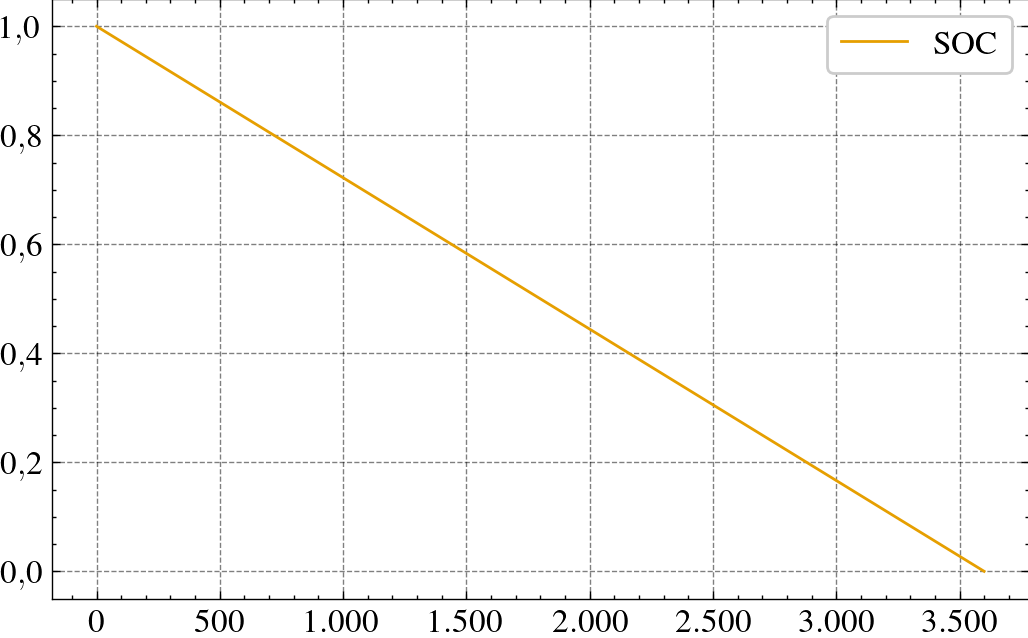

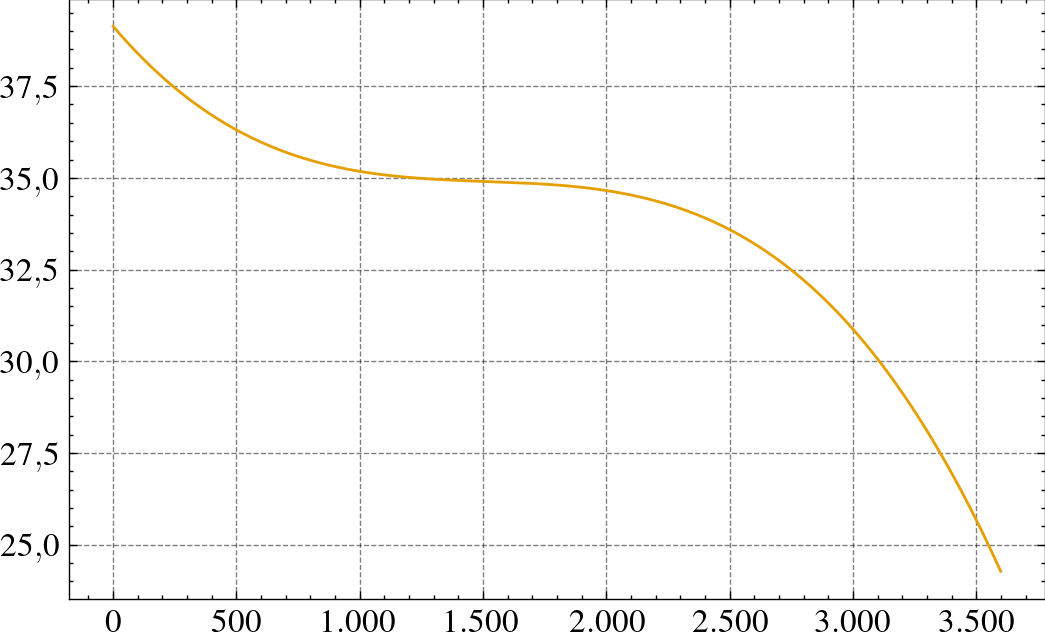

In [27]:
battery_params = { # From: nonideal_model_discrete_curve_fitting.ipynb
    'dt': GLOBAL_DT,
    'batt_eta': 1,
    'batt_Q': 136800,
    'batt_R_0': 0.11224375162849953,
    'batt_R_1': 0.00386580666181591,
    'batt_C_1': 295667374.7880665,
    'batt_coeffs': [28.520803954452276, 53.33168116956949, -90.48265858332161, 52.02806254290044]
}
battery = Battery.build(battery_params)
print(battery)

current = battery_params['batt_Q'] / 3600
print(f'current: {current}')

T = np.arange(0, 3600)

U = (current * np.ones(len(T))).T

X0 = np.zeros(battery.nstates)
X0[battery.state_index['SOC']] = 1

res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method="Radau").to_pandas()

res['SOC'].plot()
# res['battery_linear_part_I_R1'].plot()
plt.legend()

plt.figure()
res['V'].plot()

<NonlinearIOSystem>: battery
Inputs (1): ['I']
Outputs (3): ['V', 'SOC', 'OCV']
States (2): ['I_R1', 'SOC']

Update: <bound method Battery._update of <class '__main__.Battery'>>
Output: <bound method Battery._outputs of <class '__main__.Battery'>>
current: 38.0


<Axes: >

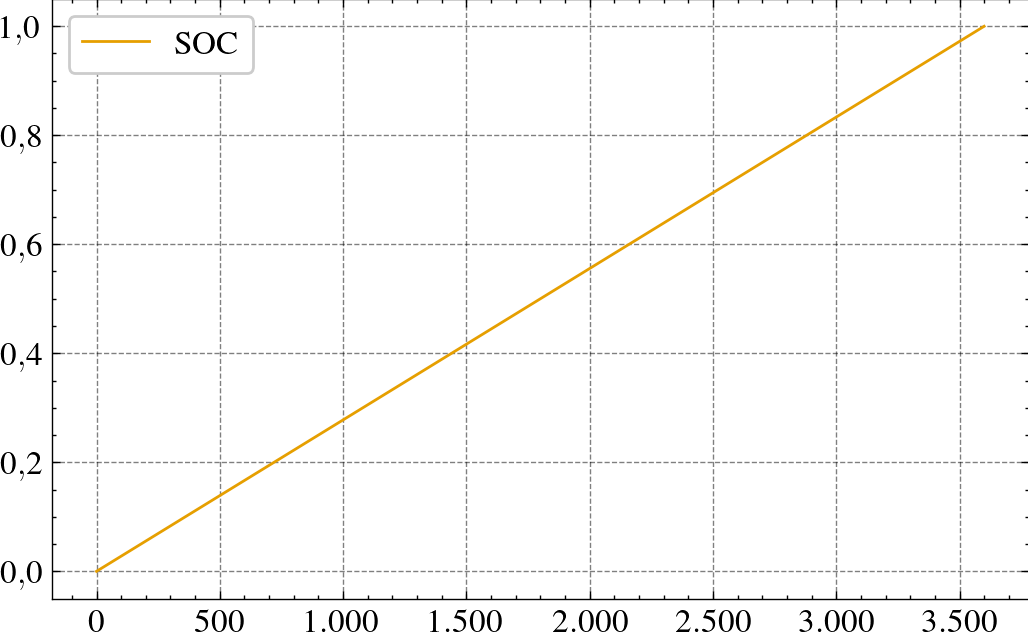

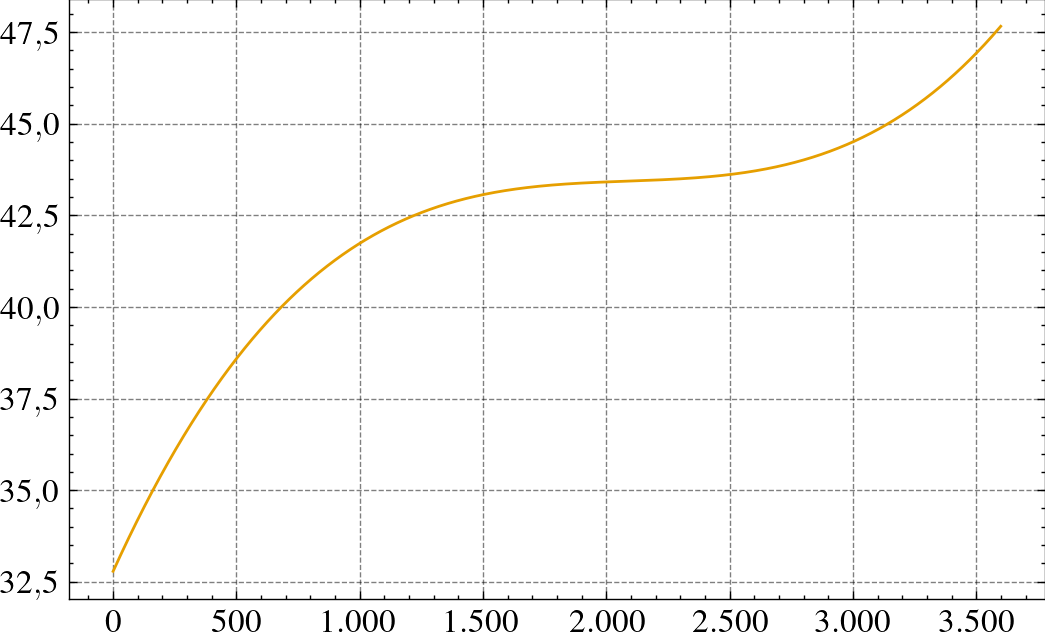

In [28]:
battery_params = { # From: nonideal_model_discrete_curve_fitting.ipynb
    'dt': GLOBAL_DT,
    'batt_eta': 1,
    'batt_Q': 136800,
    'batt_R_0': 0.11224375162849953,
    'batt_R_1': 0.00386580666181591,
    'batt_C_1': 295667374.7880665,
    'batt_coeffs': [28.520803954452276, 53.33168116956949, -90.48265858332161, 52.02806254290044]
}
battery = Battery.build(battery_params)
print(battery)

current = battery_params['batt_Q'] / 3600
print(f'current: {current}')

T = np.arange(0, 3600)

U = (-current * np.ones(len(T))).T

X0 = np.zeros(battery.nstates)
X0[battery.state_index['SOC']] = 0

res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method="Radau").to_pandas()

res['SOC'].plot()
# res['battery_linear_part_I_R1'].plot()
plt.legend()

plt.figure()
res['V'].plot()

# The Electric Boat System Model

In [29]:
electric_boat_params = battery_params | propulsion_params

In [30]:
class ElectricBoat:
    @classmethod
    def build(cls, params: dict):
        return ct.interconnect(
            [
                Battery.build(params),
                Propulsion.build(params),
            ],
            name='electric_boat',
            dt=params['dt'],
            connections=[
                ['battery.I', 'propulsion.Ii'],
                ['propulsion.Vi', 'battery.V'],
            ],
            inplist=['propulsion.D'],
            inputs=['D'],
            outlist=['battery.V', 'battery.SOC', 'propulsion.Ii', 'propulsion.w'],
            outputs=['V', 'SOC', 'I', 'w'],
        )

ElectricBoat.build(electric_boat_params)

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/control/nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (0, 2) : battery.OCV
  warn(msg)


<InterconnectedSystem:electric_boat:['D']->['V', 'SOC', 'I', 'w']>

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/control/nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (0, 2) : battery.OCV
  warn(msg)


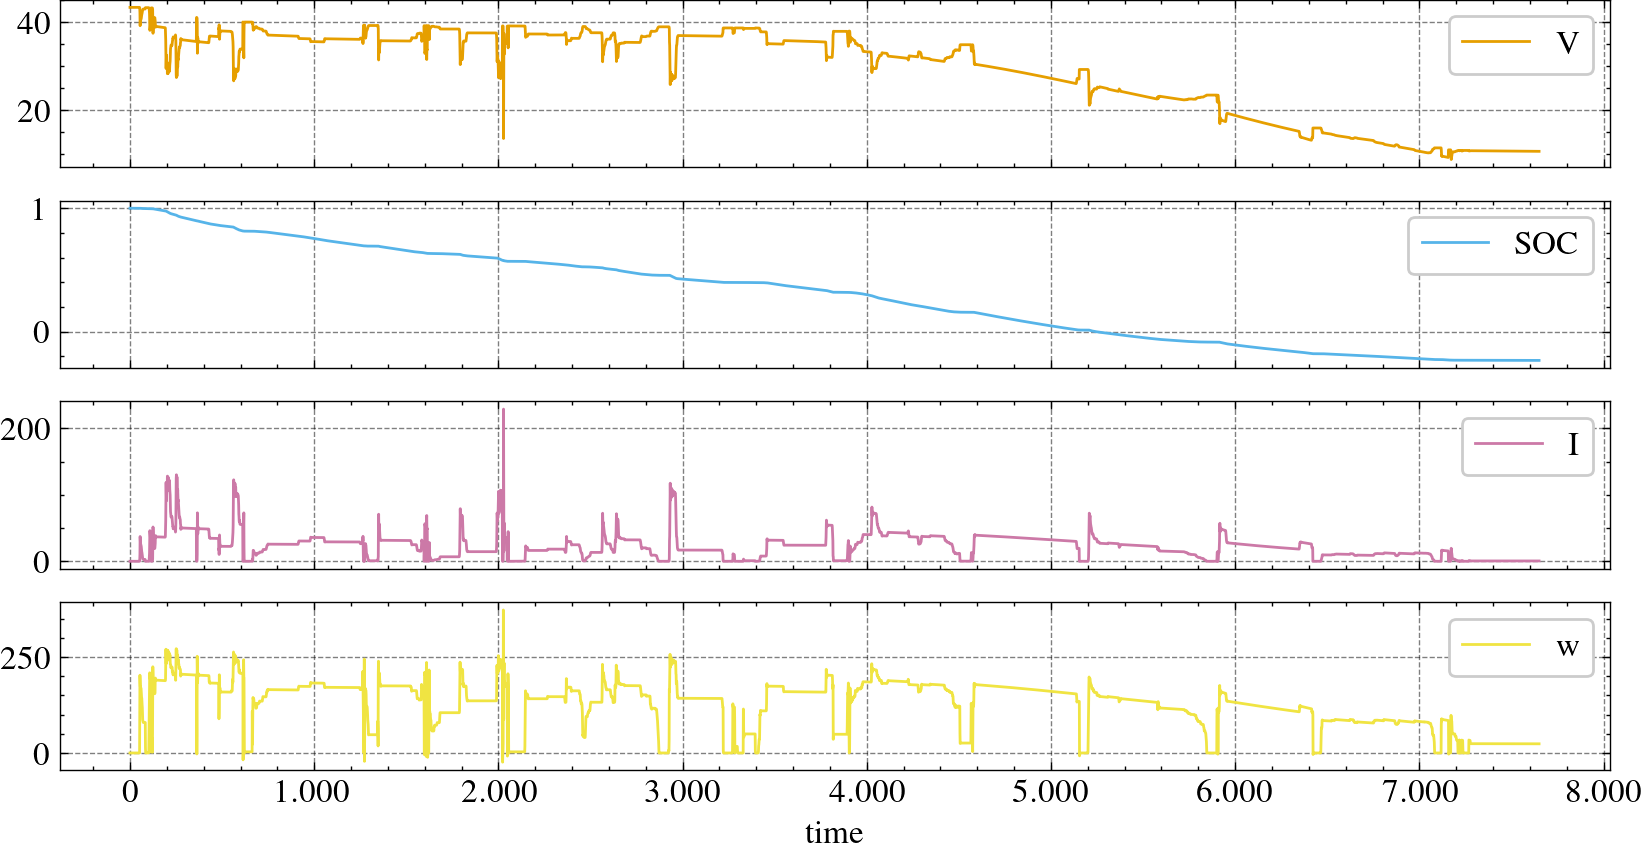

In [31]:
df = dfa.copy(deep=True)#.resample('30min').mean()
# df = df.iloc[100:102]

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['esc_dt']].to_numpy().T

electric_boat = ElectricBoat.build(electric_boat_params)

X0 = np.zeros(electric_boat.nstates)
X0[electric_boat.state_index['battery_SOC']] = 1

res = ct.input_output_response(electric_boat, T=T, U=U, X0=X0, solve_ivp_method="Radau")
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(10,5));

# Rechargeable Electric Boat System Model

In [32]:
class RechargeableElectricBoat:
    @classmethod
    def build(cls, params: dict):
        return ct.interconnect(
            (
                Battery.build(params),
                Propulsion.build(params),
                ct.summing_junction(    # Battery Current Node
                    name='battery_current',
                    inputs=['-Ii', 'Io'],
                    output='I'
                ),
            ),
            name='rechargeable_electric_boat',
            connections=[
                # ('battery_current.Ii', 'generation.Io'],
                ['battery_current.Io', 'propulsion.Ii'],
                ['battery.I', 'battery_current.I'],
                ['propulsion.Vi', 'battery.V'],
            ],
            inplist=['propulsion.D', 'battery_current.Ii'],
            inputs=['esc_dt', 'batt_ii'],
            outlist=['battery.V', 'battery.SOC', 'battery_current.I', 'battery_current.Ii', 'propulsion.Ii', 'propulsion.w'],
            outputs=['batt_v', 'batt_soc', 'batt_i', 'batt_ii', 'esc_i_in', 'motor_w'],
        )

RechargeableElectricBoat.build(electric_boat_params)


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/control/nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (0, 2) : battery.OCV
  warn(msg)


<InterconnectedSystem:rechargeable_electric_boat:['esc_dt', 'batt_ii']->['batt_v', 'batt_soc', 'batt_i', 'batt_ii', 'esc_i_in', 'motor_w']>

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/control/nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (0, 2) : battery.OCV
  warn(msg)


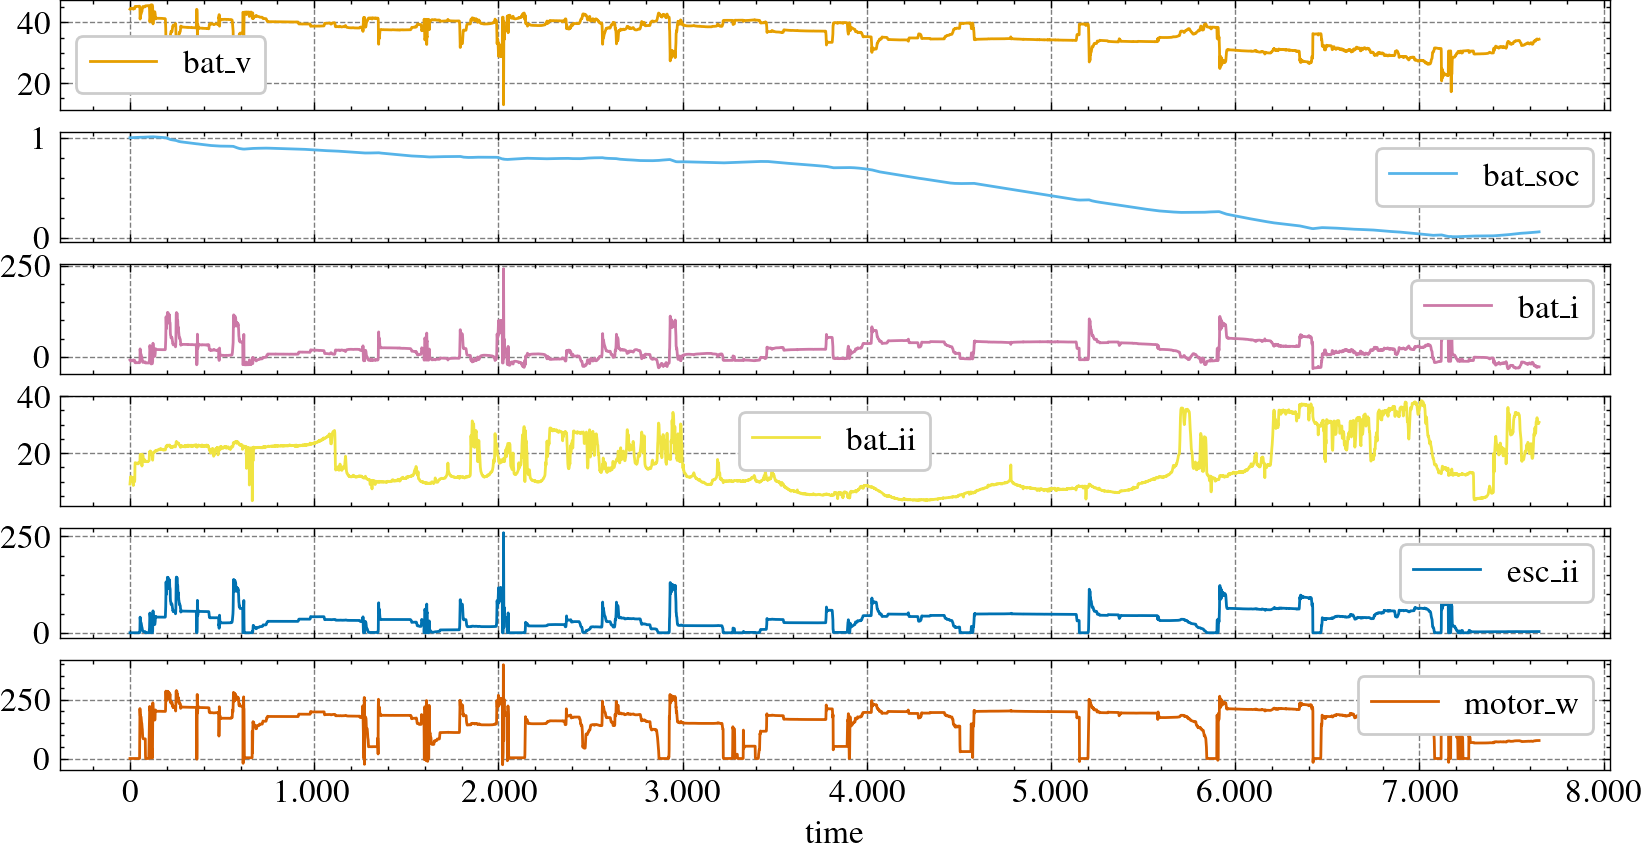

In [33]:
df = dfa.copy(deep=True)#.resample('30min').mean()
# df = df.iloc[100:102]

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['esc_dt', 'mppt1_io']].copy()
# U['esc_dt'] = U['esc_dt'].to_numpy() * 0
U['mppt1_io'] = U['mppt1_io'] * 4 # there are 4 mppts
U = U.to_numpy().T

electric_boat = RechargeableElectricBoat.build(electric_boat_params)

X0 = np.zeros(electric_boat.nstates)
X0[electric_boat.state_index['battery_SOC']] = 1

res = ct.input_output_response(electric_boat, T=T, U=U, X0=X0, solve_ivp_method="Radau")
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(10,5));

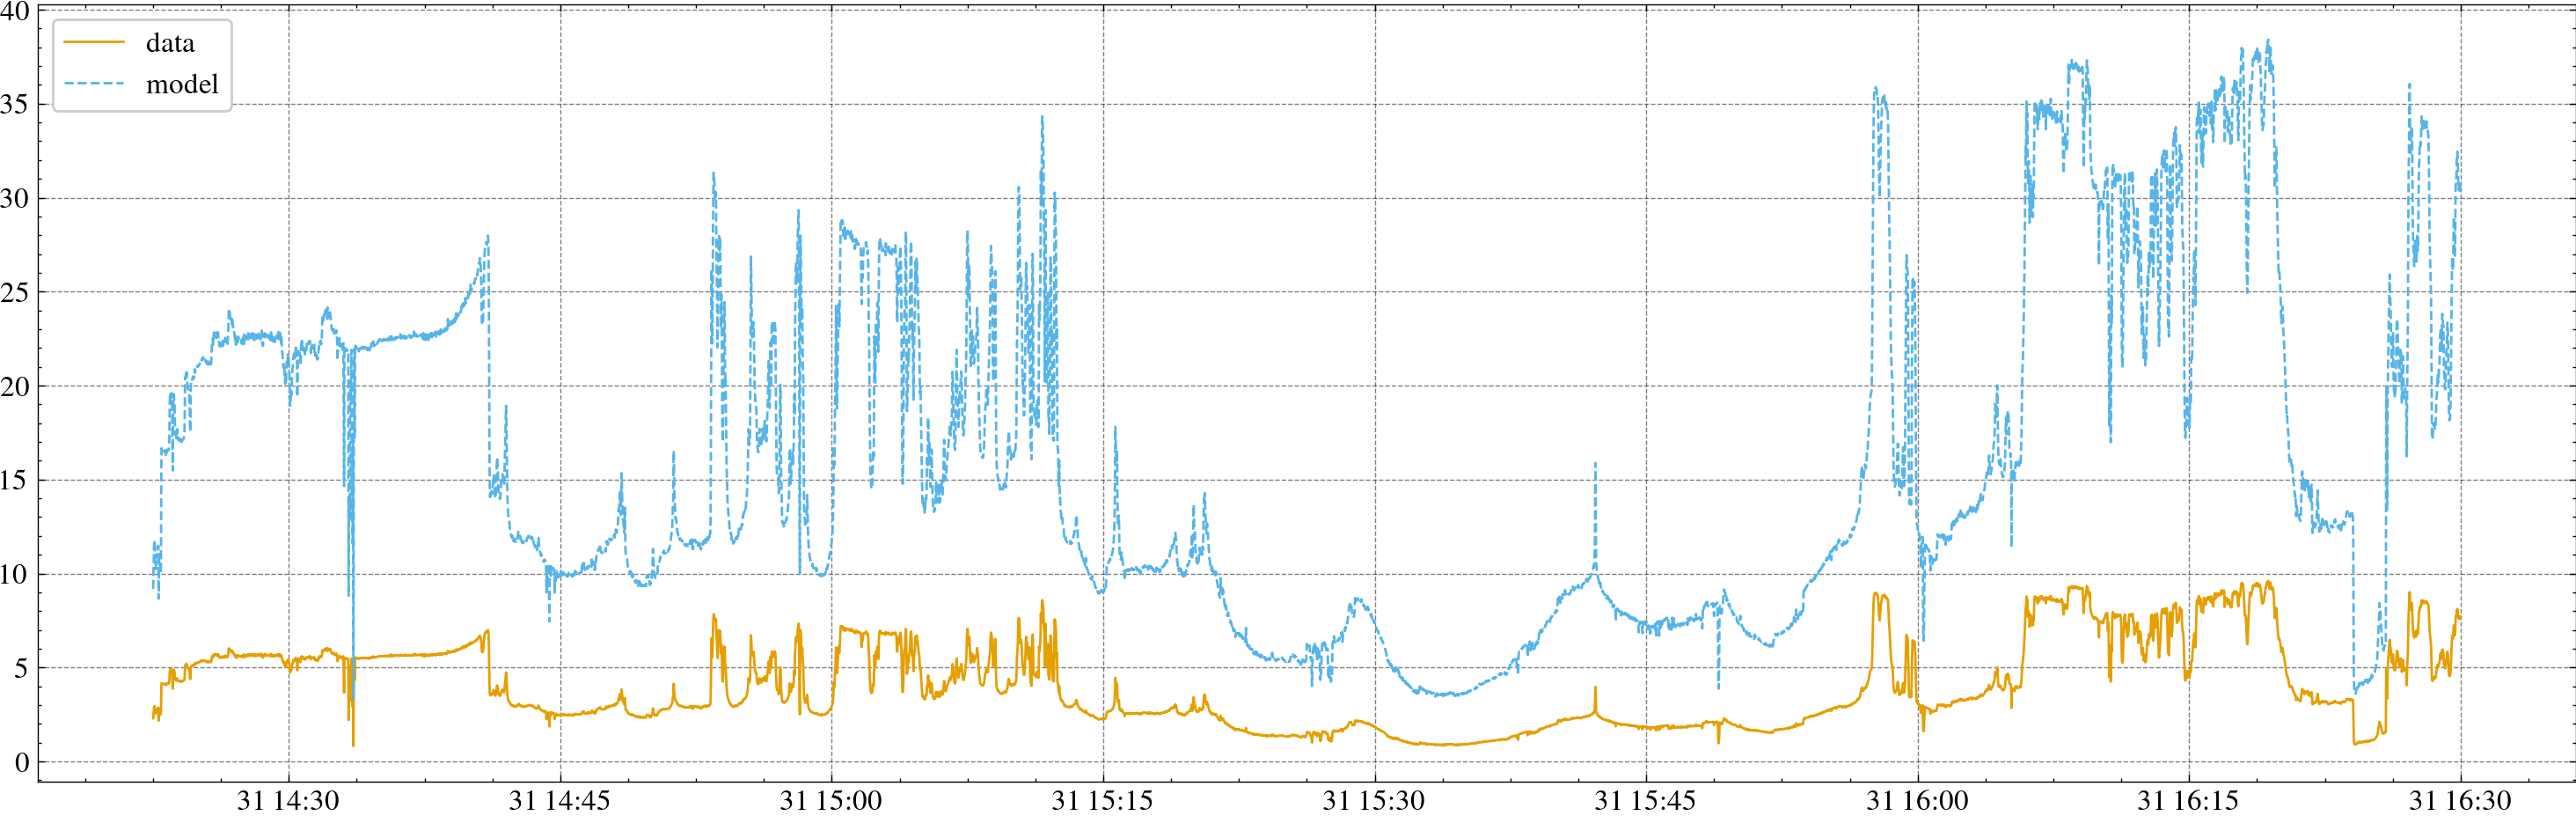

In [34]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df['mppt1_io'], label='data')
plt.plot(df.index, ydata['batt_ii'], '--', label='model')
plt.legend()
plt.tight_layout()
plt.show()

# Solar&Battery System Model

In [35]:
solar_battery_params = generation_params | battery_params

In [36]:
class SolarBattery:
    @classmethod
    def build(cls, params: dict):
        return ct.interconnect(
            [
                Generation.build(params),
                Battery.build(params),
            ],
            name='solar_battery',
            connections=[
                ['generation.Vo', 'battery.V'],
                ['battery.I', '-generation.Io'],
            ],
            inplist=['generation.G', 'generation.Ta', 'generation.vw'],
            inputs=['solar_poa', 'air_t', 'wind_v'],
            outlist=['generation.Ii', 'generation.Vi', 'battery.V', 'battery.SOC', 'generation.Tc'],
            outputs=['mppt1_ii', 'mppt1_vi', 'batt_v', 'batt_soc', 'panel_tc'],
        )

SolarBattery.build(solar_battery_params)

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/control/nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (1, 2) : battery.OCV
  warn(msg)


<InterconnectedSystem:solar_battery:['solar_poa', 'air_t', 'wind_v']->['mppt1_ii', 'mppt1_vi', 'batt_v', 'batt_soc', 'panel_tc']>

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/control/nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (1, 2) : battery.OCV
  warn(msg)


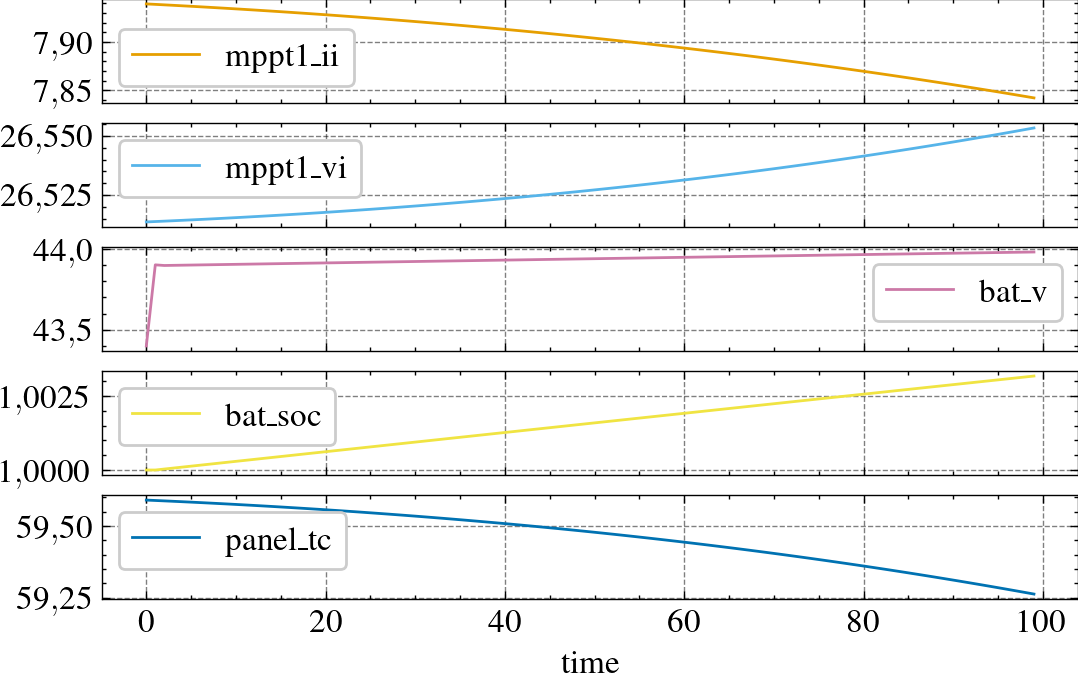

In [37]:
df = dfa.copy(deep=True)#.resample('30min').mean()
df = df.iloc[:100]

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'air_t', 'wind_v']].copy()
# U['solar_poa'] = U['solar_poa'].to_numpy()*0 + 1000
# U['air_t'] = U['air_t'].to_numpy() * 0 + 25
# U['wind_v'] = U['wind_v'].to_numpy() * 0
# U['esc_i_in'] = U['esc_i_in'].to_numpy() * 0
U = U.to_numpy().T

solar_battery = SolarBattery.build(solar_battery_params)

X0 = np.zeros(solar_battery.nstates)
# X0[solar_battery.state_index['battery_battery_linear_part_SOC']] = 1
X0[solar_battery.state_index['battery_SOC']] = 1

res = ct.input_output_response(solar_battery, T=T, U=U, X0=X0, method='Radau') # 'RK23', 'RK45', 'DOP853', 'Radau', 'BDF', 'LSODA'
ydata = input_output_response_to_pandas(res).set_index('time')[res.output_labels]

ydata.plot(subplots=True);

# Solar&Battery System Model (using SimpleGeneration model)

In [38]:
solar_battery_params = generation_params | battery_params

In [39]:
class SimpleGeneration:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        Iph_STC = params['pv_Iph_STC']
        I0_STC = params['pv_I0_STC']
        Rs_STC = params['pv_Rs_STC']
        Rp_STC = params['pv_Rp_STC']
        a_STC = params['pv_a_STC']
        Asc = params['pv_Asc']
        Eg_STC = params['pv_Eg_STC']
        dEgdT_STC = params['pv_dEgdT_STC']
        Tc_STC = params['pv_Tc_STC']
        G_STC = params['pvs_g_STC']
        alpha = params['pv_th_alpha']  # The light absorptance of the module
        u0 = params['pv_th_u0']  # Combined heat transfer coefficient at zero wind speed [(W/m^2)/C]
        u1 = params['pv_th_u1']  # Influence of wind speed on combined heat transfer coefficient [(W/m^2)/ºC/(m/s)]
        eff = params['mppt_eta']

        # Inputs
        G = u[0]  # Total incident irradiance [W/m^2]
        Ta = u[1]  # Ambient dry bulb temperature [ºC]
        vw = u[2]  # Wind speed at a height of 10 meters [m/s]
        Vo = u[3]  # MPPT output voltage (Battery voltage) [V]

        # About faiman_rad: https://datahub.duramat.org/dataset/module-temperature/resource/40f2b3ac-8415-4664-b622-c1b770c89799
        Tc = pvlib.temperature.faiman_rad(poa_global=G, temp_air=Ta, wind_speed=vw, ir_down=None, u0=u0, u1=u1, sky_view=1.0, emissivity=alpha)

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        Ii, Vi, Pi = pvlib.pvsystem.max_power_point(photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='brentq').values()

        eps = 1e-10
        Vo = np.clip(Vo, eps, 100)

        Po = Pi * eff
        Io = Po / Vo

        # M = (Vo / Vi) if Vi > 0 else 0
        # D = np.clip( M / (1 + M), a_min=0, a_max=1)

        return Io

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="generation",
            dt=params['dt'],
            states=None,
            inputs=['G', 'Ta', 'vw', 'Vo'],
            outputs=['Io'],
            params=params,
        )

SimpleGeneration.build(generation_params)


<NonlinearIOSystem:generation:['G', 'Ta', 'vw', 'Vo']->['Io']>

In [40]:
class SolarBattery:
    @classmethod
    def build(cls, params: dict):
        return ct.interconnect(
            (
                SimpleGeneration.build(params),
                Battery.build(params),
            ),
            name='solar_battery',
            connections=[
                ['generation.Vo', 'battery.V'],
                ['battery.I', '-generation.Io'],
            ],
            inplist=['generation.G', 'generation.Ta', 'generation.vw'],
            inputs=['solar_poa', 'air_t', 'wind_v'],
            outlist=['battery.I', 'battery.V', 'battery.SOC'],
            outputs=['batt_i', 'batt_v', 'batt_soc'],
        )

SolarBattery.build(solar_battery_params)

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/control/nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (1, 2) : battery.OCV
  warn(msg)


<InterconnectedSystem:solar_battery:['solar_poa', 'air_t', 'wind_v']->['batt_i', 'batt_v', 'batt_soc']>

In [41]:
# df = dfa.copy(deep=True)#.resample('30min').mean()
# # df = df.iloc[:100]

# # Time array
# T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
# lenT = len(df.index)
# T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# # Data
# U = df[['solar_poa', 'air_t', 'wind_v']].copy()
# # U['solar_poa'] = U['solar_poa'].to_numpy()*0
# # U['air_t'] = U['air_t'].to_numpy() * 0
# # U['wind_v'] = U['wind_v'].to_numpy() * 0
# U = U.to_numpy().T

# solar_battery = SolarBattery.build(solar_battery_params)

# X0 = np.zeros(solar_battery.nstates)
# # X0[solar_battery.state_index['battery_battery_linear_part_SOC']] = 0.5
# X0[solar_battery.state_index['battery_SOC']] = 0.5

# res = ct.input_output_response(solar_battery, T=T, U=U, X0=X0, method='Radau') # 'RK23', 'RK45', 'DOP853', 'Radau', 'BDF', 'LSODA'
# ydata = input_output_response_to_pandas(res).set_index('time')[res.output_labels]

# ydata.plot(subplots=True);

# Solar Boat System model

In [42]:
solar_boat_params = generation_params | battery_params | propulsion_params

In [43]:
# class SolarBoat:
#     @classmethod
#     def build(cls, params: dict, num=1):
#         return ct.interconnect(
#             (
#                 Generation.build(params),
#                 ct.summing_junction(    # Battery Current Node
#                     name='battery_current',
#                     inputs=[
#                         *[f'-Ii{n}' for n in range(1, num + 1)],
#                         'Io'
#                     ],
#                     output='I'
#                 ),
#                 Battery.build(params),
#                 Propulsion.build(params),
#             ),
#             name='solar_boat',
#             dt=params['dt'],
#             connections=(
#                 *((f'battery_current.Ii{n}', f'generation.Io{n}') for n in range(1, num + 1)),
#                 ('battery_current.Io', 'propulsion.Ii'),
#                 ('battery.I', 'battery_current.I'),
#                 ('propulsion.Vi', 'battery.V'),
#                 ('generation.Vo', 'battery.V'),
#             ),
#             inplist=('generation.G', 'generation.Ta', 'generation.wv', 'propulsion.D'),
#             inputs=('solar_poa', 'air_t', 'wind_v', 'esc_dt'),
#             outlist=(
#                 'battery.V', 'battery.SOC', 'battery_current.I',
#                 'propulsion.Ii', 'propulsion.w',
#                 *[f'generation.Ii{n}' for n in range(1, num + 1)],
#                 *[f'generation.Vi{n}' for n in range(1, num + 1)],
#                 *[f'generation.Io{n}' for n in range(1, num + 1)],
#                 *[f'generation.Tc{n}' for n in range(1, num + 1)],

#             ),
#             outputs=(
#                 'batt_v', 'batt_soc', 'batt_i',
#                 'esc_i_in', 'motor_w',
#                 *[f'mppt{n}_i_in' for n in range(1, num + 1)],
#                 *[f'mppt{n}_v_in' for n in range(1, num + 1)],
#                 *[f'mppt{n}_i_out' for n in range(1, num + 1)],
#                 *[f'mppt{n}_tc' for n in range(1, num + 1)],
#             ),
#         )

# SolarBoat.build(solar_boat_params, num=1).__dict__


In [44]:
class SolarBoat:
    @classmethod
    def build(cls, params: dict):
        return ct.interconnect(
            [
                Generation.build(params),
                ct.summing_junction(    # Battery Current Node
                    name='battery_current',
                    inputs=['-Ii', 'Io'],
                    output='I'
                ),
                Battery.build(params),
                Propulsion.build(params),
            ],
            name='solar_boat',
            dt=params['dt'],
            connections=[
                ['battery_current.Ii', 'generation.Io'],
                ['battery_current.Io', 'propulsion.Ii'],
                ['battery.I', 'battery_current.I'],
                ['propulsion.Vi', 'battery.V'],
                ['generation.Vo', 'battery.V'],
            ],
            # inplist=['generation.G', 'generation.Ta', 'generation.vw', 'propulsion.D'],
            inputs=['G', 'Ta', 'vw', 'D'],
            outlist=['battery.V', 'battery.SOC', 'battery_current.I', 'generation.Io', 'propulsion.Ii', 'propulsion.w', 'generation.Ii', 'generation.Vi', 'generation.Tc'],
            outputs=['batt_v', 'batt_soc', 'batt_i', 'batt_ii', 'esc_i_in', 'motor_w', 'mppt1_ii', 'mppt1_vi', 'mppt1_tc'],
        )

SolarBoat.build(solar_boat_params).__dict__


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/control/nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (2, 2) : battery.OCV
  warn(msg)


{'connection_type': 'explicit',
 'syslist': [<InterconnectedSystem:generation:['G', 'Ta', 'vw', 'Vo']->['Ii', 'Vi', 'Io', 'Tc']>,
  StateSpace(array([], shape=(0, 0), dtype=float64), array([], shape=(0, 2), dtype=float64), array([], shape=(1, 0), dtype=float64), array([[-1.,  1.]])),
  <NonlinearIOSystem:battery:['I']->['V', 'SOC', 'OCV']>,
  <InterconnectedSystem:propulsion:['D', 'Vi']->['Ii', 'w']>],
 'syslist_index': {'generation': 0,
  'battery_current': 1,
  'battery': 2,
  'propulsion': 3},
 'state_offset': [0, 1, 1, 3],
 'input_offset': [0, 4, 6, 7],
 'output_offset': [0, 4, 5, 8],
 'name': 'solar_boat',
 'ninputs': 4,
 'input_index': {'G': 0, 'Ta': 1, 'vw': 2, 'D': 3},
 'noutputs': 9,
 'output_index': {'batt_v': 0,
  'batt_soc': 1,
  'batt_i': 2,
  'batt_ii': 3,
  'esc_i_in': 4,
  'motor_w': 5,
  'mppt1_ii': 6,
  'mppt1_vi': 7,
  'mppt1_tc': 8},
 'nstates': 5,
 'state_index': {'generation_mppt_lp_filter_x[0]': 0,
  'battery_I_R1': 1,
  'battery_SOC': 2,
  'propulsion_motor_I': 

In [45]:
# From Revezamento
start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = vaex.from_csv("../../../models/2020/boat_data_1s.csv").to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

df = df.dropna()
df = df.resample('1s').mean().interpolate(method="time", limit_area='inside')

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/control/nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (2, 2) : battery.OCV
  warn(msg)


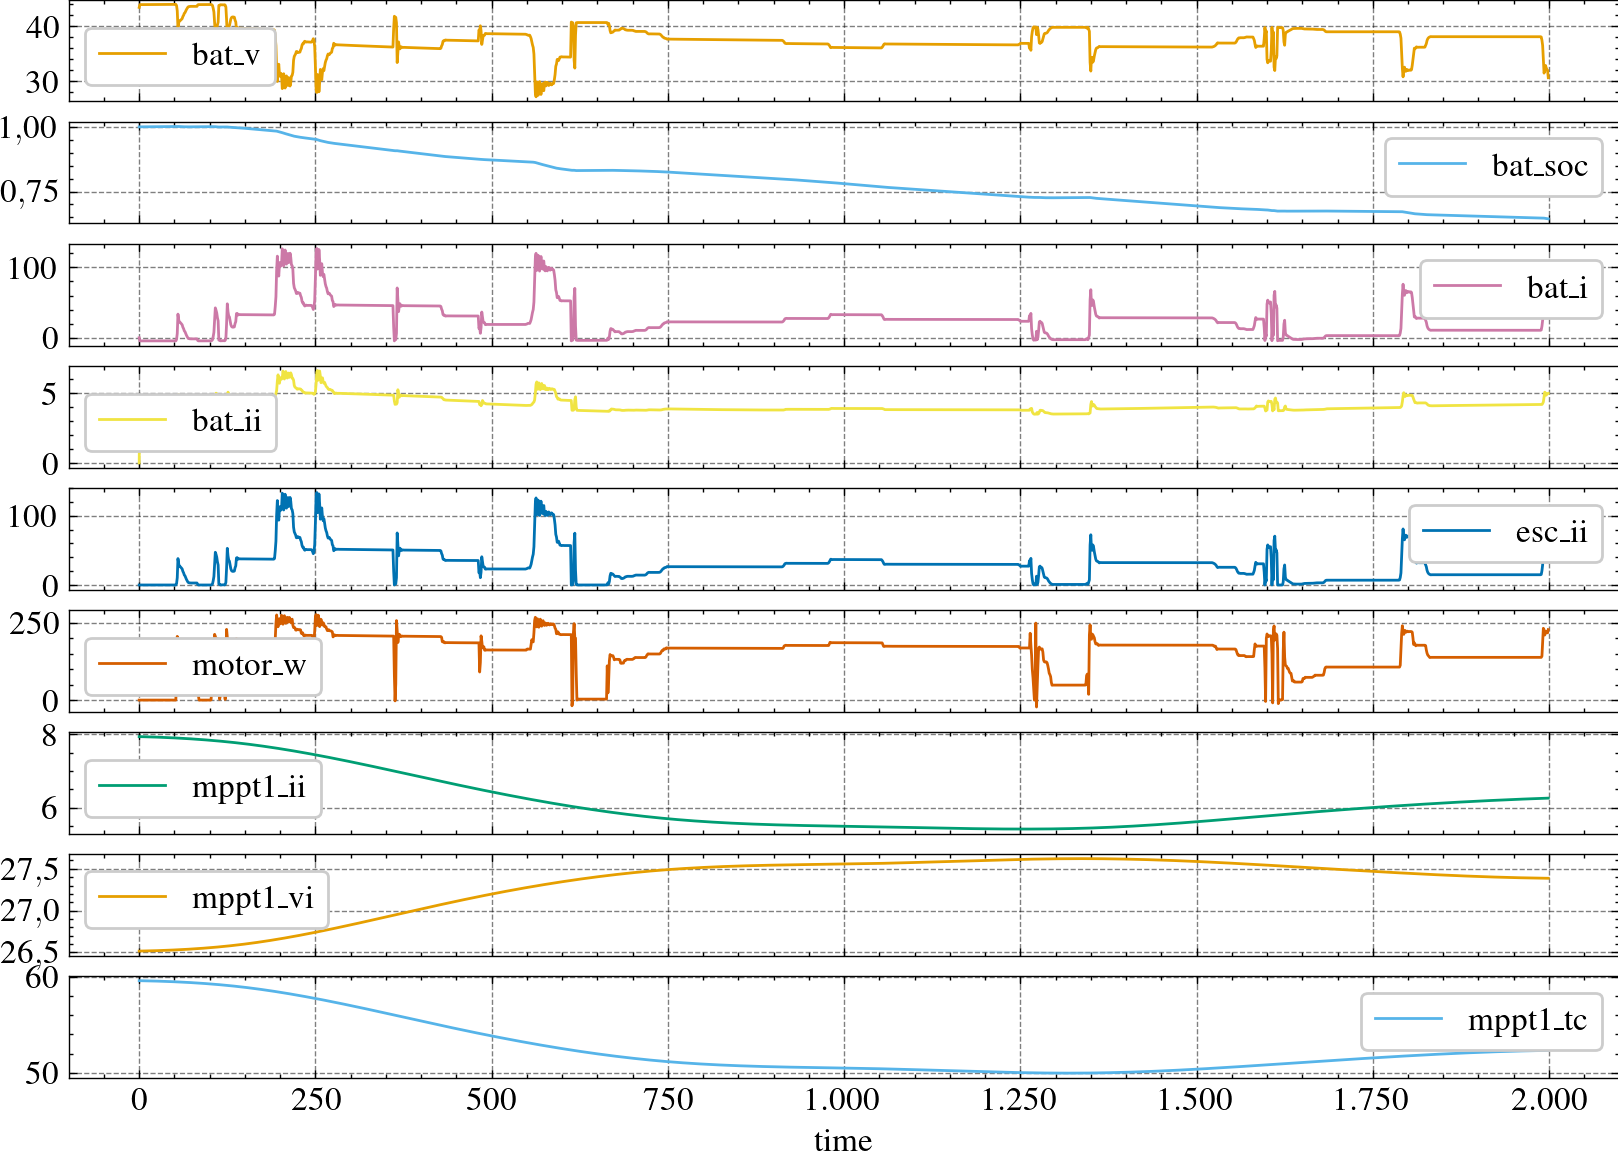

In [46]:
df = dfa.copy(deep=True)#.resample('30min').mean()
df = df.iloc[:2000]

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'air_t', 'wind_v', 'esc_dt']].to_numpy().T

solar_boat = SolarBoat.build(solar_boat_params)

X0 = np.zeros(solar_boat.nstates)
# X0[solar_boat.state_index['battery_battery_linear_part_SOC']] = 1
X0[solar_boat.state_index['battery_SOC']] = 1

res = ct.input_output_response(solar_boat, T=T, U=U, X0=X0, method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(10,7));

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/control/nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (2, 2) : battery.OCV
  warn(msg)


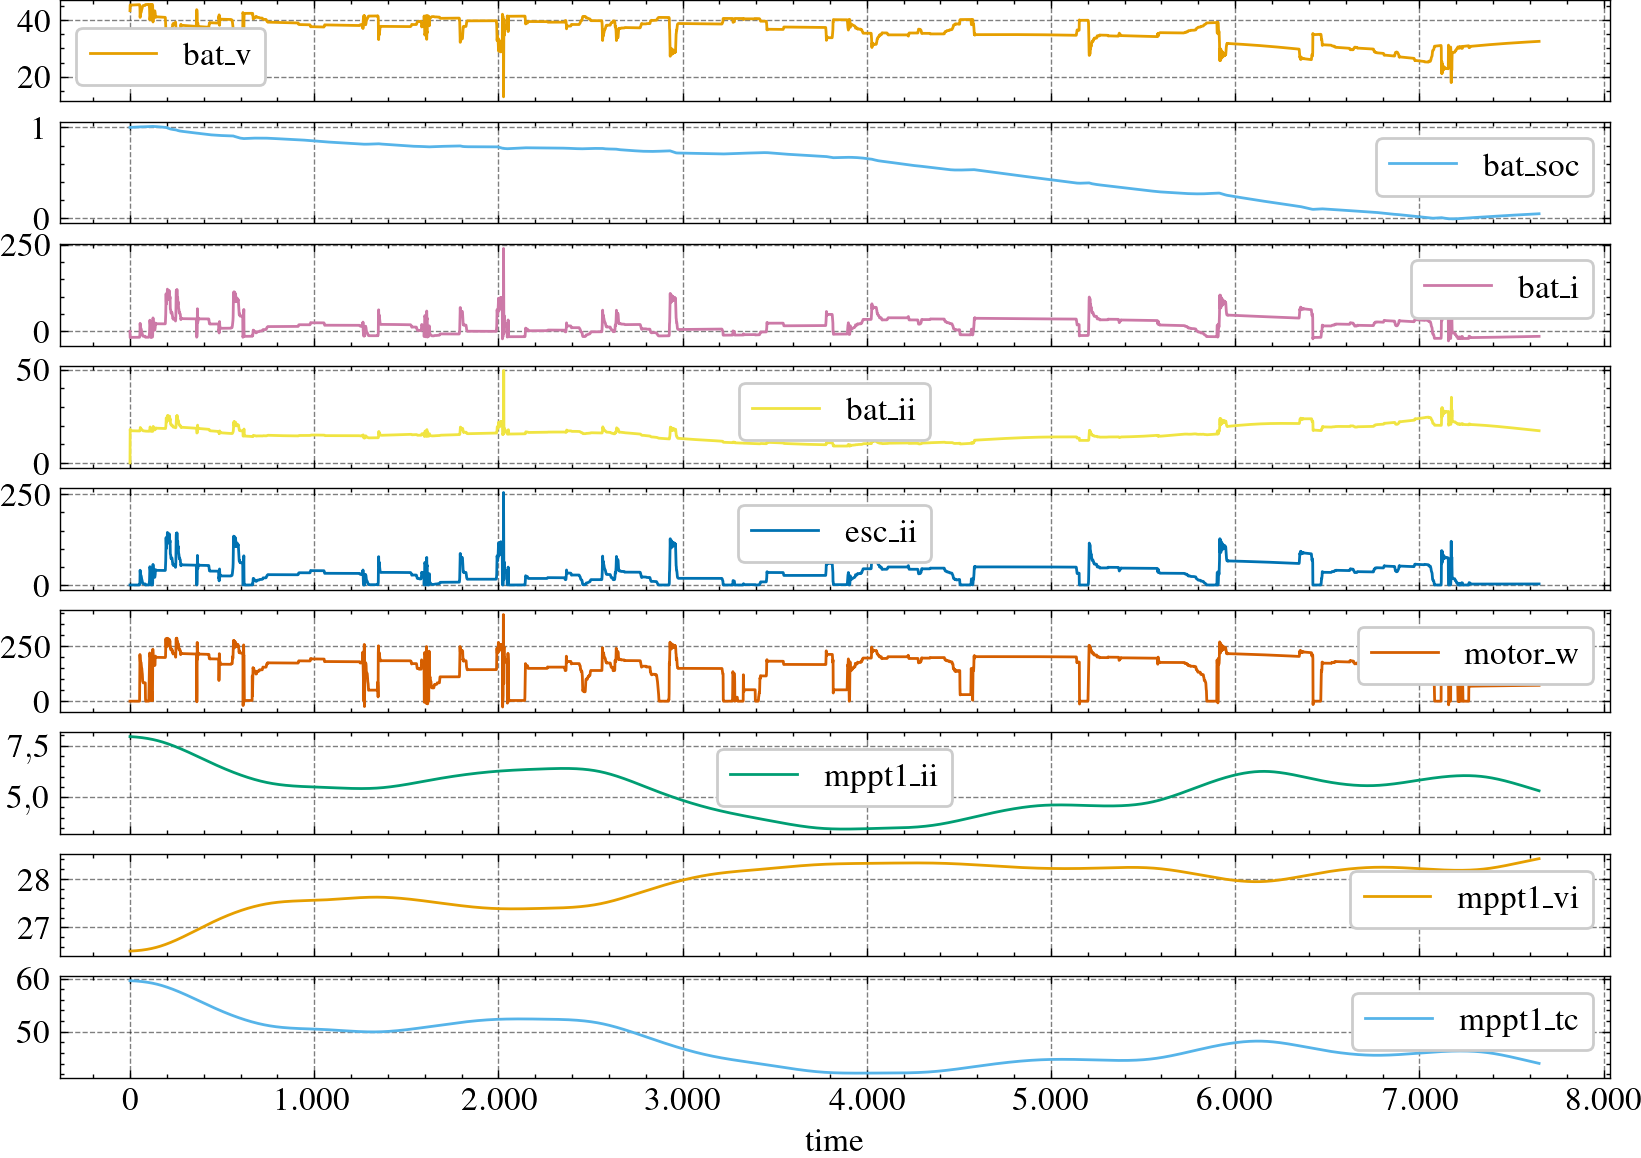

In [47]:
df = dfa.copy(deep=True)#.resample('30min').mean()
# df = df.iloc[:1000]

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'air_t', 'wind_v', 'esc_dt']].to_numpy().T

solar_boat_params['mppt_p_outwer_gain'] = 4
solar_boat = SolarBoat.build(solar_boat_params)

X0 = np.zeros(solar_boat.nstates)
X0[solar_boat.state_index['battery_SOC']] = 1

res = ct.input_output_response(solar_boat, T=T, U=U, X0=X0, method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(10,7));